<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#dmdt-function" data-toc-modified-id="dmdt-function-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>dmdt function</a></span></li></ul></li><li><span><a href="#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span></li><li><span><a href="#Optimising-reproduction" data-toc-modified-id="Optimising-reproduction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimising reproduction</a></span></li><li><span><a href="#Checking-Resource-Fluctuation" data-toc-modified-id="Checking-Resource-Fluctuation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Checking Resource Fluctuation</a></span></li></ul></div>

This notebook is to debugg / evaluate the supply model 

In [1]:
import seaborn as sb
sb.set(context='paper',style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)
from numpy import zeros_like, meshgrid, around

# Functions

In [2]:
"""
    Contains all functions and classes needed to run the notebooks and
    simulations for my Masters thesis on ontogenetic growth models done as part
    of the "Computational Methods in Ecology and Evolution" MSc at Imperial
    College London 2019/2020
"""


###### Imports ######
from numpy import arange, array
##optimisation
from numpy import unravel_index, argmax, isnan, nan_to_num, zeros
## maths functions
from scipy.integrate import odeint 
from numpy import exp, sin, pi, log10, log
## plotting
import matplotlib.pyplot as plt

###### Functions ######

## Supply Model ##
def am(m, dimensionality = "2D"):
    """
    Calculates mass specific search rate in a functional response as derived in Pawar et al 2012.

    Args:
        m (float): Mass of individual
        dimensionality (str, optional): Dimensionality of the functional response. Defaults to "3D".

    Returns:
        float: Mass specific search rate (a)
    """
    if dimensionality == "3D":
        a0 = 10** -1.77  # this is log_10(a0) in reality
        gamma = 1.05 # scarce resources
        return a0 * (m**gamma)
    
    if dimensionality == "2D":
        a0 = 10** -3.08 # this is log_10(a0) in reality
        gamma = 0.68 # scarce resources
        return a0 * (m**gamma)

def hm(m, dimensionality = "2D"):
    """
    Calculates mass specific handling time in a functional response as derived in Pawar et al 2012.

    Args:
        m (float): Mass of individual
        dimensionality (str, optional): Dimensionality of the functional response. Defaults to "3D".

    Returns:
        float: Mass specific handling time (h)
    """

    if dimensionality == "3D":
        tk0 = 10**3.04  # this is log_10(tk0) in reality
        beta = 0.75#1.1 # scarce resoruces
        return (m**-beta) * tk0

    if dimensionality == "2D":
        tk0 = 10**3.95 # this is log_10(tk0) in reality
        beta = 0.75#1.02 # scarce resoruces
        return (m**-beta) * tk0

def Xrt(t, amp, centre, period = 365):
    
    """
    To simulate the fluctuation of resource density in a functional response 
    through time according to a sine wave.

    Args:
        t (int): time passed (is converted to radians in function)
        amp (float): The amplitude of the sin wave
        centre (float): The value around which resource density fluctuates.
        period (int): Period of the wave in time. Defaults to 365


    Returns:
        float: Resource density
    """   

    x = t * (2 * pi / period) 

    return (amp * sin(x)) + centre

def Fun_Resp(m, Xr, dimensionality = "3D"):
    """
    Calculates the functional response of an organism dependent on mass.

    Args:
        m (float): Mass of individual
        ## a0 ([type]): mass dependent search rate 
        R (float): Resource density
        ## h ([type]): [description]
        dimensionality (str): Used to determine how  serach rate and handling rate are calculated. See functions for details.

    Returns:
        [float]: consumption rate of the organism
    """    
    a = am(m, dimensionality) # find mass dependent search rate
    h = hm(m, dimensionality)  # find mass dependent handling time
    
    f = (a*Xr) / (1 + a*h*Xr)
    return f

def L(t, k = 0.01):
    """
    Suvival Function for reproduction modelled as an exponetially increasing number through time.
    Based on thinking that most organisms will not live long enough for factors such as 
    reproductive senescence to be a factor.

    Args:
        t (int): Time
        k (float, optional): Reproductive senescence. Defaults to 0.01.

    Returns:
        [type]: [description]
    """
    return exp(-k*t)

def reproduction(t, c, m, rho, alpha, k = 0.01):
    """
    Calculates the reproductive output of an organisms at time `t` in terms of biomass

    Args:
        t (int): Time
        c (float): Reproductive scaling constant
        m (float): Mass of individual
        rho (float): Reproductive scaling exponent
        k (float, optional): Reproductive senescence. Defaults to 0.01.]
        
    Returns:
        float: Reproductive output in terms of biomass

    """    
    Q = L(t-alpha) # mortality

    return Q * c * (m**rho)

def metabolic_cost(mass, meta_exp=0.76):
    """
    Calculates the metabolic cost of an organism in term of mass/time

    Args:
        m (float): Mass of individual (units: mass)
        metabolic_rate (float): The standard metabolic rate or resting metabolic rate of the organism (units: energy * mass / time)
        conversion_factor ([type]): Value for how much energy is in a unit of mass (units: energy / mass)

    Returns:
        float: The "mass cost" of the organism at the given mass
    """
    # routine rate
    alpha = 0.76
    intercept = exp(-5.71)
    return intercept * (m**alpha)



## dmdt function
All other functions appear to be behaving as expected with the exception of this when integrating

In [3]:
def dmdt(mR0, t, 
         alpha, epsilon, norm_const, meta_prop, meta_exp, 
         c, rho, 
         Xr, amp, period, dimensionality = "3D"):
    """
    Calculates the instantaneous change in mass at time `t`. 

    Args:
        m (float): Mass of individual
        t (int): time
        alpha (int): maturation time
        epsilon (float): Efficiency term
        c (float): Metabolic cost constant
        rho (float): Metabolic cost exponent
        Xr (float): The expected median value for resource density
        amp (float): amplitude of resource fluctuation around `Xr`
        period (int): the period (duration) of the resource cycle
        dimensionality (str): See `Func_Resp`


    Returns:
        float: change in mass (dm/dt) at time t
    """
    
    # check if individual is at/past maturation
    m, R = mR0
    k = 0.01 #  reproductive senesence
    if t < alpha:
        R = 0 # reproductive cost
    repro = 0 # reproductive output
    if t >= alpha:
        R = c * norm_const * (m**rho) # kg/d
        repro = repro_out = reproduction(t, c*norm_const, m, rho, alpha, k = 0.1)

    # Gain
    Xr_t = Xrt(t, amp, Xr, period)
    gain = epsilon * Fun_Resp(m, Xr, dimensionality) # kg/s
    gain = gain * (60 * 60 * 24)# /s -> /min -> /hour -> /day
    # Loss
    B_m  = norm_const * meta_prop * m**meta_exp  
    loss = B_m + R
    
    dmdt =  gain - loss
    
    # check for shrinking
    if dmdt + m < 0:
        dmdt = -m

        
    return array([dmdt, repro])
    

In [4]:
m = 1
Xr = 10**6
dimensionality="2D"
epsilon = 0.5
c= 0.2
rho = 0.2

gain = Fun_Resp(m, Xr, dimensionality) # kg/s
gain = gain * (60 * 60 * 24)# /s -> /min -> /hour -> /day

B_m  = metabolic_cost(m) # g C/d
B_m = B_m * 11 # g wetmass/day
B_m = B_m / 1000 # g/d -> kg/d
loss = B_m+(c*m**rho)

print("gain", gain)
print("loss",loss)
    
m

gain 9.694238137452219
loss 0.2000364393979939


1

In [5]:
import Functions as F
m = 1
Xr = 10**6
dimensionality="2D"
epsilon = 0.5
c= 0.2
rho = 0.2

F.Fun_Resp(m, Xr, dimensionality)* (60 * 60 * 24)# /s -> /min -> /hour -> /day
# gain = Fun_Resp(m, Xr, dimensionality) # kg/s
# gain = gain * (60 * 60 * 24)# /s -> /min -> /hour -> /day
# gain

9.694238137452219

# Code
**Current Issues**
- model is gaining mass too fast and over one time step metabolic cost exceeds it greatly and causes "shrinking".

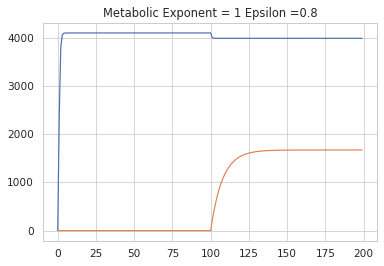

In [6]:
# params = {"alpha" : 200, "epsilon" : 0.8,
#           "c" : 1, "rho" : 1,
#           "Xr" : 10**6, "amp" : 0.5, "period" : 365}

m0 = 0.1
R0 = 0
time = 200
alpha = 100
epsilon = 0.8
#normalisation constant,1kg fish at high resources in 2D
norm_const = Fun_Resp(1, 10**6, "3D")* (60 * 60 * 24)# /s -> /min -> /hour -> /day 
meta_prop = 0.1 # proportion of norm_const that is metabolic cost
meta_exp = 1 # metabolic cost exponent
c = 0.1
rho = 0.4
Xr = 10**6
amp = 0
period = 365
dimensionality = "3D"

t= arange(0,time,1)
mR0 = array([m0,R0])
params = (alpha, epsilon, norm_const, meta_prop, meta_exp,
          c, rho,
          Xr, amp, period, dimensionality)

res = odeint(func=F.dmdt, y0=mR0, t=t, args=params, full_output=True)
# repro_res = res[:,1][-1] #  final repro
# mass_res = res[:,0][-1]
    # res = dmdt_integrate(m0, R0, time, params)


plt.plot(t, res[0][:,0])
plt.plot(t, res[0][:,1])
plt.title("Metabolic Exponent = " + str(meta_exp)+ " Epsilon =" + str(epsilon))
plt.savefig("../results/output.pdf")

In [7]:
res[0][100,0] # mass


4096.000807288957

In [8]:
break# jsut to kill before optimisation when rerunning notebook

SyntaxError: 'break' outside loop (<ipython-input-8-7da5556f9e93>, line 1)

# Optimising reproduction

In [ ]:
# scanning rho and c values
resolution = 0.1
c_vec = arange(0.1, 2, resolution) # constant values
rho_vec = arange(0.1, 2, resolution) #exponent values
c_mat, rho_mat = meshgrid(c_vec, rho_vec)
mass_matrix = zeros_like(c_mat) #  to store final mass values
repro_matrix = zeros_like(c_mat)#  to store final reproductive output values

    
for i, rho in enumerate(rho_vec):
    for j, c in enumerate(c_vec):
        params = (alpha, epsilon, norm_const, meta_prop, meta_exp,
                  c, rho,
                  Xr, amp, period, dimensionality)

        res = odeint(func=dmdt, y0=mR0, t=t, args=params)
#         plt.plot(t, res[:,0], label="Mass")
#         plt.plot(t, res[:,1], label="Repro")
        res = nan_to_num(res, nan=0) # remove nan from the running
        res = res[-1]
#         if res[-1][0] <= res[alpha][0]:# if mass less than at maturation
#             res = [0,0]
#         else:
#             res = res[-1]

        mass_matrix[i,j] = res[0]
        repro_matrix[i,j] =res[1]

In [ ]:
sb.heatmap(mass_matrix, 
           xticklabels = around(c_vec, decimals=1), 
           yticklabels= around(rho_vec, decimals=1)).invert_yaxis()
plt.ylabel("c")
plt.xlabel("rho")
plt.title("Mass")

plt.figure()
sb.heatmap(repro_matrix, 
           xticklabels = around(c_vec, decimals=1), 
           yticklabels= around(rho_vec, decimals=1)).invert_yaxis()
plt.ylabel("c")
plt.xlabel("rho")
plt.title("Reproduction")


# Checking Resource Fluctuation 

In [ ]:
t= arange(1,10**3,1)
m= arange(1,10**3,1)
resources = 100
Xr = Xrt(t, 0.5, resources, 365)
plt.figure()
plt.plot(t, Xr)

plt.figure()
plt.plot(t, Fun_Resp(m, Xr))